# Investigating SAT scores in NYC's public schools

The SAT is a standardized test required for admission to many universities and colleges in the United States. New York City has the United States's largest school system with over 1.1 million students and over 1,800 schools. The purpose of this project is to examine whether there are any correlations between SAT test scores and demographic and educational aspects in New York City's public school system.

### Read in the data
In addition to the SAT scores, we will use other demographic and education data provided by NYC.

In [34]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

#create a dictionary with the file name as the key and the dataframe as its values
for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Read in the surveys
Every school has an unique id associated with it. This is the `DBN`. We will use this number to combine the data sets.

In [35]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0, sort = False)

#copy the data from dbn into a new column called DBN
survey["DBN"] = survey["dbn"]

#these are the survey fields we are interested in
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
#filter `survey` to just those fields we are interested in
survey = survey.loc[:,survey_fields]

#assign the dataframe to the key `survey`
data["survey"] = survey

### Add DBN columns
Some of the data sets do not contain the DBN number but have the information to determine what the DBN would be. `hs_directory` has `dbn` so we will add a `DBN` column with the `dbn` information. `class_size` does not but it contains the information we need to generate the `DBN` number.

In [36]:
#create a new column DBN with the dbn data in hs_directory
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    """Takes in a number. Converts the number to a string using the str() function. 
    Check the length of the string using the len() function. If the string is two digits long, returns the string. 
    If the string is one digit long, adds a 0 to the front of the string, then returns it.
    """
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation

#apply pad_csd to class_size CSD and creates a new column padded_csd
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)

#creates a new column DBN in class_size
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### SAT total score and geographic coordinates
We want to have a total SAT score to compare across different factors and it would be helpful to have the latitude and longitude coordinates for each school to help uncover any geographic patterns in the data.

In [37]:
#converting the average scores for math, reading, and writing to numeric form to get the total
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

#extracting the latitude and longitude from the hs_directory data set in the Location 1 field
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

#convert the lat and long data to numeric values
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets
The `class_size`, `graduation` and `demographics` datasets have multiple rows with the same `DBN`. We need to combine these rows into a single one so they can be combined with the single matching entry in `sat_results`. 

In [38]:
#filtering the data set for just high school grades and general education
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

#class_size still contains multiple DBNs. groupby the DBN and then take the mean of each subgroup
#This gives us the mean for each DBN
class_size = class_size.groupby("DBN").agg(numpy.mean)
#DBN is index after groupby, need to reset the index and make DBN a column again
class_size.reset_index(inplace=True)
data["class_size"] = class_size

#DBN in the demographics data set is not unique because of the schoolyear column. Select the 2011-2012 school year
#because it is the latest year and it matches the SAT results data
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]


#DBN is not unique because of the demographic and cohort columns
#we will select the total cohort from the demographic column and 2006 from the cohort column
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric

In [39]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the datasets


In [40]:
combined = data["sat_results"]

#ap_2010 and graudation has a lot of missing DBNs so we will left merge with sat_results
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

#these data sets have more information that is valuable and there are fewer missing values so we will use an inner join
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

# fill the missing values with the mean
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add a school district column for mapping

In [41]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

### Finding correlations with SAT scores
We are interested in the correlations with the `sat_score` column.

In [42]:
correlations = combined.corr()
correlations = correlations["sat_score"]

#set to print all rows
pd.set_option('display.max_rows', None)

print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

Some observations from this comparison:

- `AVERAGE CLASS SIZE` has a strong positive correlation with `sat_score`.
- `fem_per` (percentage of females) has a weak positive correlation whereas `male_per` does not.
- There is significant racial inequality in SAT scores (`white_per`, `asian_per`, `black_per`, `hispanic_per`)
- The percentage of English language learners (`ell_percent`, `frl_percent`) has a strong negative correlation with SAT scores.

## Plotting correlations between SAT scores and survey fields

In [43]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

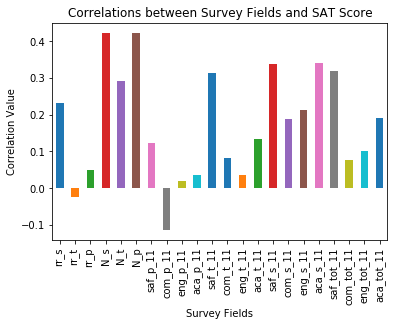

In [44]:
import matplotlib.pyplot as plt

#bar plot of correlations between the survey_fields and sat_score
%matplotlib inline
ax = combined.corr()['sat_score'][survey_fields].plot.bar(title = "Correlations between Survey Fields and SAT Score")
ax.set_xlabel('Survey Fields')
ax.set_ylabel('Correlation Value')

plt.savefig('survey_fields_sat_scores.jpg')

### Correlations between SAT scores and survey fields
There is a strong correlation between SAT scores and the number student, parent, and teacher respondents (`N_s`,  `N_p`, `N_t`). Safety and respect scores (`saf_t_11`, `saf_s_11`, `saf_tot_11`) also correlate with SAT scores. Student academic expectations (`aca_s_11`) also had a strong correlation with the SAT scores, but teacher and parent academic expectations (`aca_t_11`, `aca_p_11`) do not.


## Exploring safety

### Student safety scores

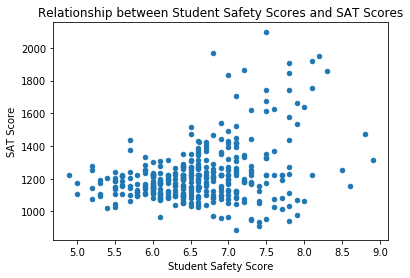

In [45]:
ax = combined.plot.scatter('saf_s_11', 'sat_score', title="Relationship between Student Safety Scores and SAT Scores")
ax.set_xlabel("Student Safety Score")
ax.set_ylabel("SAT Score")

plt.savefig('safety_sat.jpg')

There is a weak correlation between student safety scores and the SAT score. There are some outliers of very high SAT scores and safety scores. Most of the scores are clustered around safety values between 6 and 7 and SAT scores between 1100 and 1500.

### Borough safety 

In [46]:
boro = combined.groupby('boro').agg(numpy.mean)['saf_s_11']
print(boro)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


Manhattan and Queens have the highest safety averages, whereas Brooklyn has the lowest.

## Exploring SAT scores by race

### Correlations between racial groups and SAT scores

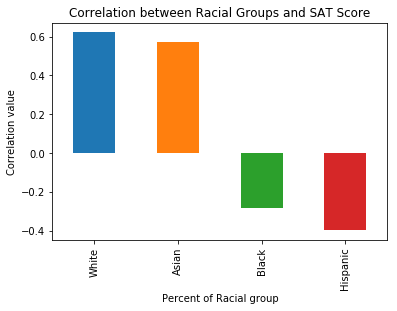

In [47]:
racial_fields = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
ax = combined.corr()['sat_score'][racial_fields].plot.bar(title='Correlation between Racial Groups and SAT Score')
ax.xaxis.set(ticklabels = ["White", "Asian", "Black", "Hispanic"])
ax.set_xlabel("Percent of Racial group")
ax.set_ylabel('Correlation value')

plt.savefig('race_sat.jpg')

Racial categories correlate significantly with SAT scores. SAT scores of white and Asian students have a positive correlation while the scores of Black and Hispanic students correlate negatively.

### Exploring schools with high percentage of Hispanic students

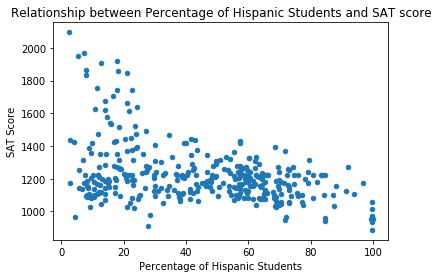

In [66]:
ax = combined.plot.scatter('hispanic_per', 'sat_score', title = "Relationship between Percentage of Hispanic Students and SAT score")
ax.set_xlabel("Percentage of Hispanic Students")
ax.set_ylabel('SAT Score')

plt.savefig('hisp_per_sat.jpg')

SAT scores correlates negatively with the percentage of Hispanic students at a school. To see what's going on here we will look at the schools with high (>95%) and low (<10%) percent of Hispanic students.

In [49]:
#what is the value type in hispanic_per?
print(combined['hispanic_per'].dtype)

float64


In [50]:
print(combined[combined['hispanic_per']>95]['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools where Hispanic students make up more than 95% of the student body are schools that are focused on English language learners (ELL) education. They include schools that are dedicated to recent immigrants.

In [51]:
print(combined['sat_score'].dtype)

float64


In [52]:
high_sat = combined['sat_score'] > 1000
low_hisp = combined['hispanic_per']<10

print(combined[high_sat & low_hisp]['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
192                          BEDFORD ACADEMY HIGH SCHOOL
194                            BENJAMIN BANNEKER ACADEMY
220                           BOYS AND GIRLS HIGH SCHOOL
223    ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...
226               THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP
227                         SCHOOL FOR HUMAN RIGHTS, THE
228                  SCHOOL FOR DEMOCRACY AND LEADERSHIP
229    HIGH SCHOOL FOR YOUTH AND COMMUNITY DEVELOPMEN...
230        HIGH SCHOOL FOR SERVICE & LEARNING AT ERASMUS
231    SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
236                             CLARA BARTON HIGH SCHOOL
238                           BROOKLYN GENERATION SCHOOL
240              KURT HAHN EXPE

The schools where Hispanic students make up less than 10% of the population and the SAT scores are greater than 1000 include the city's selective technical and science preparatory schools. This doesn't explain the low number of Hispanic students at these schools, but it does make sense that these schools would have higher SAT scores.

## Exploring SAT scores by gender

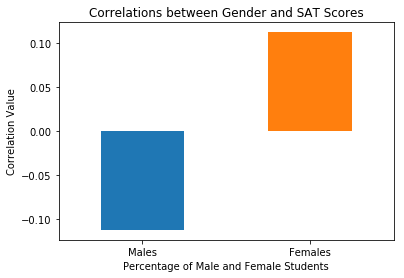

In [53]:
gender_cat = ['male_per', 'female_per']
ax = combined.corr()['sat_score'][gender_cat].plot.bar(title = "Correlations between Gender and SAT Scores", rot=0)
ax.xaxis.set(ticklabels = ["Males", "Females"])
ax.set_xlabel("Percentage of Male and Female Students")
ax.set_ylabel("Correlation Value")

plt.savefig('gender_sat.jpg')

The percentage of female students has a weak positive correlation to SAT scores. The percentage of male students has a weak negative correlation to SAT scores.

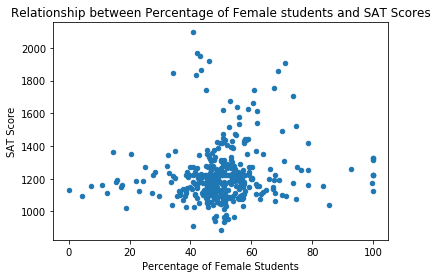

In [67]:
ax = combined.plot.scatter('female_per', 'sat_score', title="Relationship between Percentage of Female students and SAT Scores")
ax.set_xlabel("Percentage of Female Students")
ax.set_ylabel("SAT Score")

plt.savefig('fem_per_sat.jpg')

Schools with very low percentage of female students as well as those with very high percentage of female students perform equally well, with maximum scores near 1400. Some schools that are between 40% and 75% female have SAT scores above 1600.

In [55]:
high_female = combined['female_per']>60
high_f_sat = combined['sat_score']>1700
print(combined[high_female & high_f_sat]['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools with more than 60% female students and SAT scores over 1700 are highly rated high schools with a focus on college preparatory and college courses.

## Exploring the relation between educational aspects and SAT scores

### AP courses and SAT scores
Advanced placement (AP) courses are college-level courses that are offered in some high schools. Students can receive college credit if they pass the AP test with a certain score.

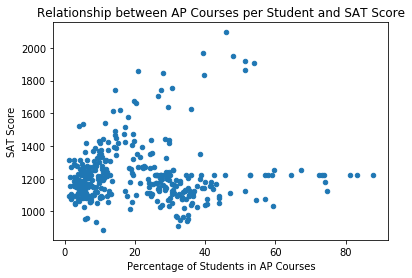

In [68]:
#percentage of students in each school that took an AP exam
combined['ap_per'] = (combined['AP Test Takers ']/combined['total_enrollment'])*100

ax = combined.plot.scatter('ap_per', 'sat_score', title = "Relationship between AP Courses per Student and SAT Score")
ax.set_xlabel("Percentage of Students in AP Courses")
ax.set_ylabel("SAT Score")

plt.savefig('ap_sat.jpg')

In [57]:
combined.corr()['ap_per']['sat_score']

0.057170813907669614

There is just a weak correlation between number of AP test takes and the SAT score. AP exams are based on course work and are different than the SAT. Students who take AP courses and exams wouldn't necessarily do better on a standardized exam.

### Advanced Regents exams and SAT scores
In order to graduate from high school in New York, students must pass five [Regents exams](https://www.schools.nyc.gov/learning/student-journey/grade-by-grade/testing/ny-state-high-school-regents-exams). An Advanced Regents diploma, the highest level diploma the state offers, requires additional exams in math, science, and a language other than English.

In [58]:
#changing the advanced regents value from object to numeric
combined['Advanced Regents - % of cohort_numeric'] = combined['Advanced Regents - % of cohort'].str.replace('%', '')
combined['Advanced Regents - % of cohort_numeric'] = pd.to_numeric(combined['Advanced Regents - % of cohort_numeric'], errors = 'coerce')


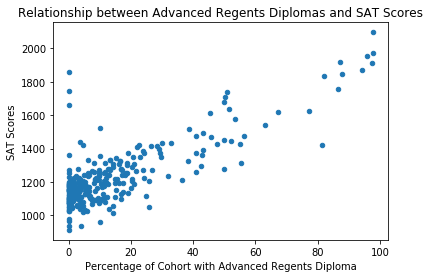

In [69]:
ax = combined.plot.scatter('Advanced Regents - % of cohort_numeric', 'sat_score', title = "Relationship between Advanced Regents Diplomas and SAT Scores")
ax.set_xlabel("Percentage of Cohort with Advanced Regents Diploma")
ax.set_ylabel("SAT Scores")

plt.savefig('adv_regents_sat.jpg')

In [60]:
combined.corr()['Advanced Regents - % of cohort_numeric']['sat_score']

0.8064065891547011

High percentages of advanced Regents diplomas in a cohort correlates strongly with high SAT scores. This is a stronger correlation than AP exam classes.

### Class size and SAT scores

In [61]:
combined.corr()['AVERAGE CLASS SIZE']['sat_score']

0.3810143308095523

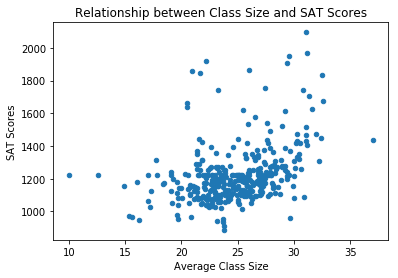

In [70]:
#comparing the average class size to SAT scores
ax = combined.plot.scatter('AVERAGE CLASS SIZE', 'sat_score', title = "Relationship between Class Size and SAT Scores")
ax.set_xlabel("Average Class Size")
ax.set_ylabel("SAT Scores")

plt.savefig('class_size_sat.jpg')

There is a positive correlation between average class size and SAT scores. This is surprising because large class sizes is usually associated with poorer student performance.

In [63]:
combined.corr()['AVERAGE CLASS SIZE']['sat_score']

0.3810143308095523

In [64]:
large_class = combined['AVERAGE CLASS SIZE']>27
high_c_sat = combined['sat_score']> 1700
print(combined[large_class & high_c_sat]['SCHOOL NAME'])

26                         ELEANOR ROOSEVELT HIGH SCHOOL
37                                STUYVESANT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
302                          TOWNSEND HARRIS HIGH SCHOOL
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [65]:
small_class = combined['AVERAGE CLASS SIZE']<22
low_c_sat = combined['sat_score'] < 1000
print(combined[small_class & low_c_sat]['SCHOOL NAME'])

91                  INTERNATIONAL COMMUNITY HIGH SCHOOL
126                     BRONX INTERNATIONAL HIGH SCHOOL
176    PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
188                  BROOKLYN INTERNATIONAL HIGH SCHOOL
237                          IT TAKES A VILLAGE ACADEMY
286              PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Looking at schools with large average class sizes and high SAT scores as well as schools with small average class size and low SAT scores revealed that the former are selective schools that need to be tested into and the latter are international schools geared towards ELL students.

# Summary
In this project I cleaned and merged data from eight different data sets to examine correlations with SAT scores in NYC's public high schools. I examined relationships between safety scores, race, gender, AP classes, Advanced Regents diplomas, and average class size.

If I continued this research I would work with the location data and would look into property prices to see if there is any relation between property prices and SAT scores.